In [1]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import soundfile
from collections import Counter
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [3]:
dataset_folders = [
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_01",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_02",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_03",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_04",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_05",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_06",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_07",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_08",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_09",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_10",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_11",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_12",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_13",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_14",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_15",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_16",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_17",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_18",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_19",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_20",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_21",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_22",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_23",
    r"D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_24",
   
]


In [4]:
def extract_emotion_mapping(dataset_folder):
    emotion_mapping = {}
    
    for filename in os.listdir(dataset_folder):
        if filename.endswith('.wav'):
            emotion_code = filename.split('-')[2]
            emotion_name = emotion_dict.get(emotion_code, "Unknown")
            if emotion_code not in emotion_mapping:
                emotion_mapping[emotion_code] = emotion_name

    return emotion_mapping

all_emotion_mappings = {}

for folder in dataset_folders:
    emotion_mapping = extract_emotion_mapping(folder)
    all_emotion_mappings[folder] = emotion_mapping

for folder, mapping in all_emotion_mappings.items():
    print(f"Emotion mapping for {folder}:")
    print(mapping)

Emotion mapping for D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_01:
{'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
Emotion mapping for D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_02:
{'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
Emotion mapping for D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_03:
{'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
Emotion mapping for D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_04:
{'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
Emotion mapping for D:\project\dataset\speech-emotion-recognition-ravdess-data\Actor_05:
{'01': 'neutral', '02': 'calm', '03': 'happ

In [5]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sample_rate)
    features = np.concatenate((np.mean(mfccs.T, axis=0),
                               np.mean(chroma.T, axis=0),
                               np.mean(mel_spectrogram.T, axis=0),
                               np.mean(spectral_contrast.T, axis=0),
                               np.mean(tonnetz.T, axis=0)), axis=0)
    return features

def extract_features_with_labels(dataset_base_folder, emotion_dict):
    all_features = []
    all_labels = []

    for actor_folder in os.listdir(dataset_base_folder):
        actor_path = os.path.join(dataset_base_folder, actor_folder)

        if os.path.isdir(actor_path):
            print(f"Processing: {actor_folder}")

            for filename in os.listdir(actor_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(actor_path, filename)
                    emotion_code = filename.split('-')[2]
                    emotion_label = emotion_dict.get(emotion_code, "Unknown")
                    features = extract_features(file_path)
                    all_features.append(features)
                    all_labels.append(emotion_label)

    return np.array(all_features), np.array(all_labels)

dataset_base_folder = dataset_base_folder = r"D:\project\dataset\speech-emotion-recognition-ravdess-data"


features_all, labels_all = extract_features_with_labels(dataset_base_folder, emotion_dict)

print(f"Extracted Features Shape: {features_all.shape}")
print(f"Extracted Labels Shape: {labels_all.shape}")


Processing: Actor_01
Processing: Actor_02
Processing: Actor_03
Processing: Actor_04
Processing: Actor_05
Processing: Actor_06
Processing: Actor_07
Processing: Actor_08
Processing: Actor_09
Processing: Actor_10
Processing: Actor_11
Processing: Actor_12
Processing: Actor_13
Processing: Actor_14
Processing: Actor_15
Processing: Actor_16
Processing: Actor_17
Processing: Actor_18
Processing: Actor_19
Processing: Actor_20
Processing: Actor_21
Processing: Actor_22
Processing: Actor_23
Processing: Actor_24
Extracted Features Shape: (1440, 166)
Extracted Labels Shape: (1440,)


In [6]:
def count_samples_per_emotion(labels):
    label_counts = Counter(labels)
    return label_counts

def determine_minimum_samples(label_counts):
    min_samples = min(label_counts.values())
    return min_samples

def balance_dataset(features, labels, min_samples):
    balanced_features = []
    balanced_labels = []
    features_list = features.tolist()
    labels_list = labels.tolist()
    unique_emotions = np.unique(labels)

    for emotion in unique_emotions:
        emotion_features = [features_list[i] for i, label in enumerate(labels_list) if label == emotion]

        if len(emotion_features) > min_samples:
            emotion_features = resample(emotion_features, n_samples=min_samples, random_state=42)

        elif len(emotion_features) < min_samples:
            emotion_features = resample(emotion_features, n_samples=min_samples, random_state=42, replace=True)

        balanced_features.extend(emotion_features)
        balanced_labels.extend([emotion] * min_samples)
    
    return np.array(balanced_features), np.array(balanced_labels)

label_counts = count_samples_per_emotion(labels_all)
print(f"Initial emotion sample counts: {label_counts}")

min_samples = determine_minimum_samples(label_counts)
print(f"Minimum number of samples for balancing: {min_samples}")

balanced_features, balanced_labels = balance_dataset(features_all, labels_all, min_samples)

print(f"Balanced Features Shape: {balanced_features.shape}")
print(f"Balanced Labels Shape: {balanced_labels.shape}")

balanced_label_counts = count_samples_per_emotion(balanced_labels)
print(f"Balanced emotion sample counts: {balanced_label_counts}")

Initial emotion sample counts: Counter({np.str_('calm'): 192, np.str_('happy'): 192, np.str_('sad'): 192, np.str_('angry'): 192, np.str_('fearful'): 192, np.str_('disgust'): 192, np.str_('surprised'): 192, np.str_('neutral'): 96})
Minimum number of samples for balancing: 96
Balanced Features Shape: (768, 166)
Balanced Labels Shape: (768,)
Balanced emotion sample counts: Counter({np.str_('angry'): 96, np.str_('calm'): 96, np.str_('disgust'): 96, np.str_('fearful'): 96, np.str_('happy'): 96, np.str_('neutral'): 96, np.str_('sad'): 96, np.str_('surprised'): 96})


In [7]:
def split_dataset(features, labels, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, stratify=labels, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(balanced_features, balanced_labels)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

print(f"Training Labels Distribution: {Counter(y_train)}")
print(f"Testing Labels Distribution: {Counter(y_test)}")

Training Features Shape: (614, 166)
Testing Features Shape: (154, 166)
Training Labels Shape: (614,)
Testing Labels Shape: (154,)
Training Labels Distribution: Counter({np.str_('neutral'): 77, np.str_('surprised'): 77, np.str_('happy'): 77, np.str_('calm'): 77, np.str_('disgust'): 77, np.str_('angry'): 77, np.str_('fearful'): 76, np.str_('sad'): 76})
Testing Labels Distribution: Counter({np.str_('fearful'): 20, np.str_('sad'): 20, np.str_('calm'): 19, np.str_('neutral'): 19, np.str_('surprised'): 19, np.str_('disgust'): 19, np.str_('happy'): 19, np.str_('angry'): 19})


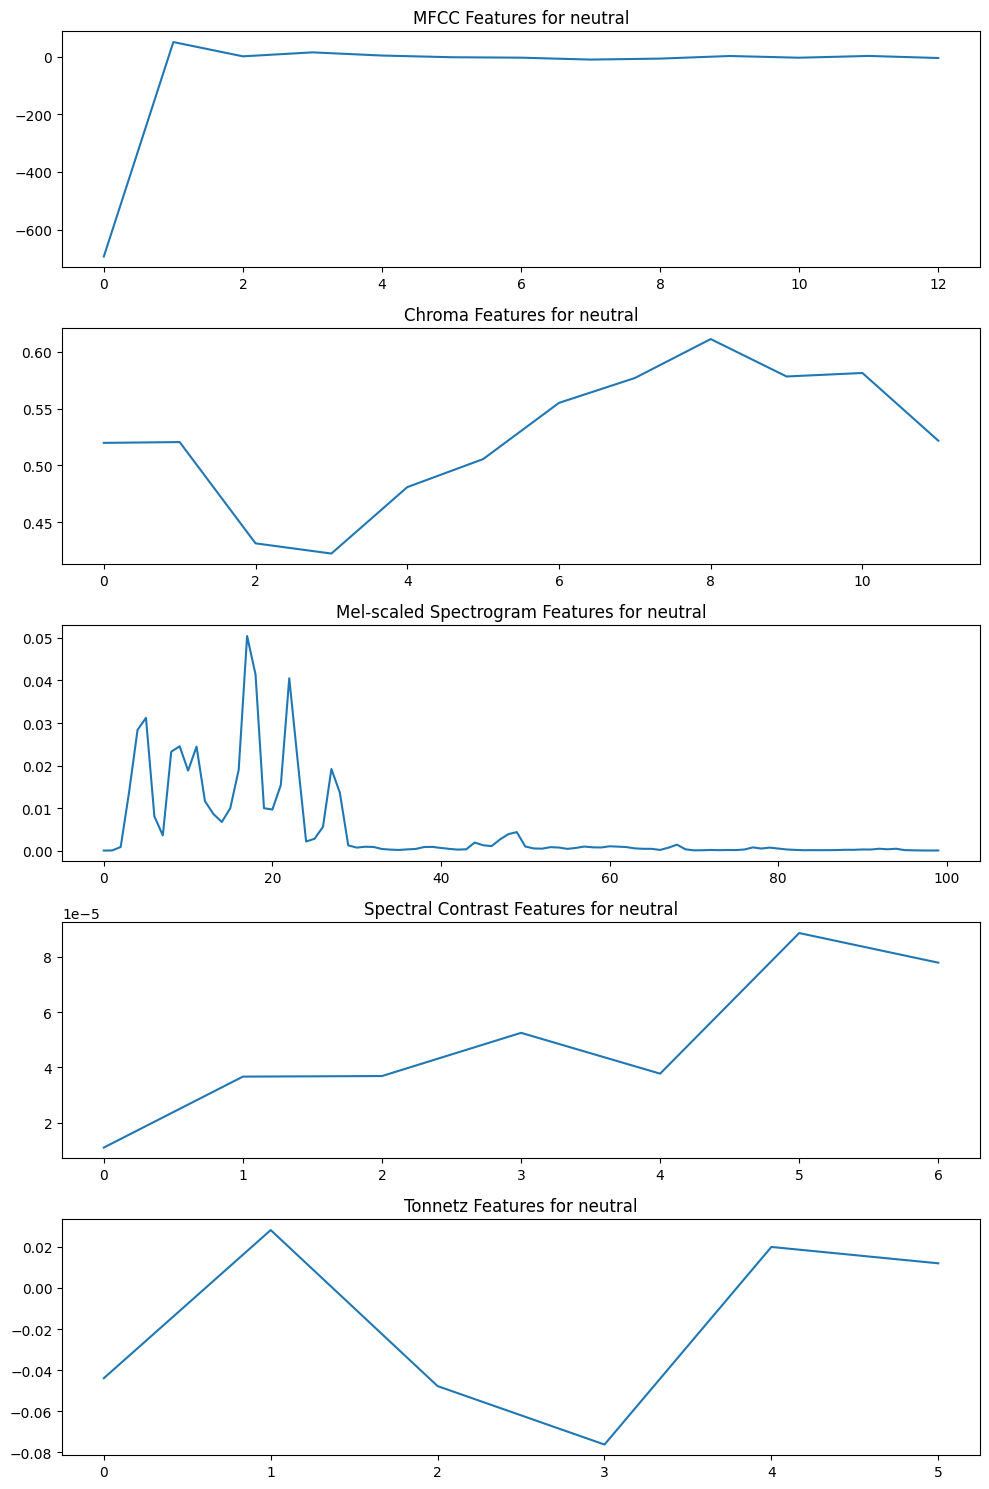

In [8]:
mfcc_features = 13
chroma_features = 12
mel_features = 100
spectral_contrast_features = 7
tonnetz_features = 6

def visualize_features(features, labels, index=0):
    mfcc = features[index][:mfcc_features]
    chroma = features[index][mfcc_features:mfcc_features + chroma_features]
    mel_spectrogram = features[index][mfcc_features + chroma_features:mfcc_features + chroma_features + mel_features]
    spectral_contrast = features[index][mfcc_features + chroma_features + mel_features:mfcc_features + chroma_features + mel_features + spectral_contrast_features]
    tonnetz = features[index][-tonnetz_features:]
    
    emotion_label = labels[index]

    fig, axs = plt.subplots(5, 1, figsize=(10, 15))

    axs[0].plot(mfcc)
    axs[0].set_title(f'MFCC Features for {emotion_label}')

    axs[1].plot(chroma)
    axs[1].set_title(f'Chroma Features for {emotion_label}')

    axs[2].plot(mel_spectrogram)
    axs[2].set_title(f'Mel-scaled Spectrogram Features for {emotion_label}')

    axs[3].plot(spectral_contrast)
    axs[3].set_title(f'Spectral Contrast Features for {emotion_label}')

    axs[4].plot(tonnetz)
    axs[4].set_title(f'Tonnetz Features for {emotion_label}')
    
    plt.tight_layout()
    plt.show()

visualize_features(features_all, labels_all, index=0)

In [9]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_all)

print(f"Encoded labels: {labels_encoded}")
print(f"Original labels: {label_encoder.inverse_transform(labels_encoded)}")

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_all)

print(f"Scaled Features Shape: {features_scaled.shape}")
print(f"Encoded Labels Shape: {labels_encoded.shape}")

Encoded labels: [5 5 5 ... 7 7 7]
Original labels: ['neutral' 'neutral' 'neutral' ... 'surprised' 'surprised' 'surprised']
Scaled Features Shape: (1440, 166)
Encoded Labels Shape: (1440,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    early_stopping=True
)

mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 51.39%
Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.55      0.64        42
        calm       0.62      0.66      0.64        44
     disgust       0.39      0.69      0.50        32
     fearful       0.46      0.59      0.52        32
       happy       0.48      0.47      0.48        34
     neutral       0.27      0.15      0.19        20
         sad       0.38      0.38      0.38        39
   surprised       0.68      0.47      0.55        45

    accuracy                           0.51       288
   macro avg       0.51      0.49      0.49       288
weighted avg       0.54      0.51      0.51       288

Confusion Matrix:
[[23  0  9  7  1  1  0  1]
 [ 0 29  4  0  1  4  6  0]
 [ 0  1 22  1  2  0  2  4]
 [ 1  0  5 19  4  1  1  1]
 [ 3  2  4  5 16  0  3  1]
 [ 0  6  3  0  1  3  6  1]
 [ 1  9  3  3  4  2 15  2]
 [ 2  0  6  6  4  0  6 21]]


In [11]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (128, 64), (256, 128, 64)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.1),
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(0.001, 0.01),
    'max_iter': [200, 300, 400],
}

mlp_model = MLPClassifier(random_state=42, early_stopping=True)

random_search = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Model Test Accuracy: {accuracy * 100:.2f}%")

print("Optimized Model Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'activation': 'tanh', 'alpha': np.float64(0.06193860093330873), 'hidden_layer_sizes': (256, 128, 64), 'learning_rate': 'constant', 'learning_rate_init': np.float64(0.010832308858067883), 'max_iter': 200, 'solver': 'adam'}
Optimized Model Test Accuracy: 56.25%
Optimized Model Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.71      0.74        42
        calm       0.56      0.64      0.60        44
     disgust       0.58      0.66      0.62        32
     fearful       0.54      0.59      0.57        32
       happy       0.43      0.44      0.43        34
     neutral       0.19      0.15      0.17        20
         sad       0.53      0.49      0.51        39
   surprised       0.66      0.60      0.63        45

    accuracy                           0.56       288
   macro avg       0.53      0.53      0.53       288
weighted avg       0.

In [12]:
basic_mlp_model = MLPClassifier(random_state=42, max_iter=200)
basic_mlp_model.fit(X_train, y_train)

y_pred_basic = basic_mlp_model.predict(X_test)

basic_accuracy = accuracy_score(y_test, y_pred_basic)
print(f"Basic Model Test Accuracy: {basic_accuracy * 100:.2f}%")
print("Basic Model Classification Report:")
print(classification_report(y_test, y_pred_basic, target_names=label_encoder.classes_))

y_pred_optimized = best_model.predict(X_test)

optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Model Test Accuracy: {optimized_accuracy * 100:.2f}%")
print("Optimized Model Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=label_encoder.classes_))

Basic Model Test Accuracy: 57.29%
Basic Model Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.67      0.70        42
        calm       0.59      0.61      0.60        44
     disgust       0.46      0.66      0.54        32
     fearful       0.62      0.62      0.62        32
       happy       0.51      0.62      0.56        34
     neutral       0.39      0.35      0.37        20
         sad       0.55      0.44      0.49        39
   surprised       0.67      0.53      0.59        45

    accuracy                           0.57       288
   macro avg       0.57      0.56      0.56       288
weighted avg       0.58      0.57      0.57       288

Optimized Model Test Accuracy: 56.25%
Optimized Model Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.71      0.74        42
        calm       0.56      0.64      0.60        44
     disgust       0.58      0.66      0

d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Basic Model Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.67      0.70        42
        calm       0.59      0.61      0.60        44
     disgust       0.46      0.66      0.54        32
     fearful       0.62      0.62      0.62        32
       happy       0.51      0.62      0.56        34
     neutral       0.39      0.35      0.37        20
         sad       0.55      0.44      0.49        39
   surprised       0.67      0.53      0.59        45

    accuracy                           0.57       288
   macro avg       0.57      0.56      0.56       288
weighted avg       0.58      0.57      0.57       288

Optimized Model Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.71      0.74        42
        calm       0.56      0.64      0.60        44
     disgust       0.58      0.66      0.62        32
     fearful       0.54      0.59      0.57        32
    

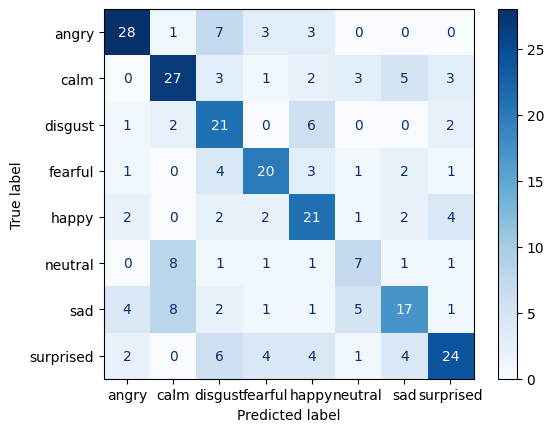

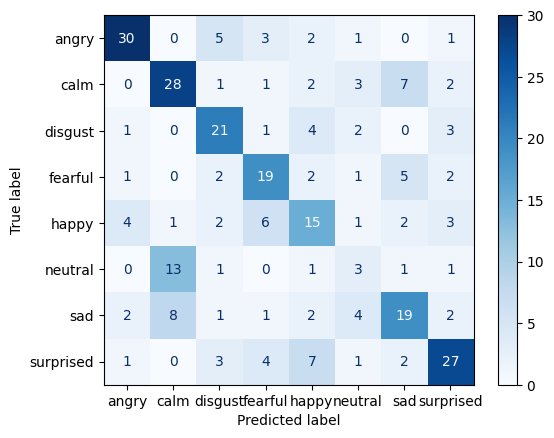

In [13]:
print("Basic Model Classification Report:")
print(classification_report(y_test, y_pred_basic, target_names=label_encoder.classes_))

print("Optimized Model Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=label_encoder.classes_))

print("Basic Model Confusion Matrix:")
conf_matrix_basic = confusion_matrix(y_test, y_pred_basic)
print(conf_matrix_basic)

ConfusionMatrixDisplay(conf_matrix_basic, display_labels=label_encoder.classes_).plot(cmap='Blues')

print("Optimized Model Confusion Matrix:")
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
print(conf_matrix_optimized)

ConfusionMatrixDisplay(conf_matrix_optimized, display_labels=label_encoder.classes_).plot(cmap='Blues')

plt.show()


In [14]:
param_dist = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

random_search = RandomizedSearchCV(estimator=basic_mlp_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42)

random_search.fit(X_train, y_train)

optimized_mlp_model = random_search.best_estimator_

d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perc

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define K-Fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = 'accuracy'

print("K-Fold Cross-Validation for Optimized MLP Model")
cv_scores_optimized = cross_val_score(optimized_mlp_model, X_train, y_train, cv=kf, scoring=scorer)

print(f"Cross-validation scores (Optimized Model): {cv_scores_optimized}")
print(f"Mean accuracy (Optimized Model): {cv_scores_optimized.mean():.4f}")
print(f"Standard deviation (Optimized Model): {cv_scores_optimized.std():.4f}")


K-Fold Cross-Validation for Optimized MLP Model


d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-validation scores (Optimized Model): [0.47186147 0.55844156 0.53478261 0.53913043 0.54782609]
Mean accuracy (Optimized Model): 0.5304
Standard deviation (Optimized Model): 0.0304


d:\project\emotion_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
svm_model = SVC(kernel='linear', random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

In [17]:
svm_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [18]:
y_pred_svm = svm_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

In [19]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"Performance Metrics for {model_name}:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

print("Basic MLP Model Evaluation:")
evaluate_model(y_test, y_pred_basic, "Basic MLP Model")

print("Optimized MLP Model Evaluation:")
evaluate_model(y_test, y_pred_optimized, "Optimized MLP Model")

evaluate_model(y_test, y_pred_svm, "SVM Model")

evaluate_model(y_test, y_pred_knn, "KNN Model")


Basic MLP Model Evaluation:
Performance Metrics for Basic MLP Model:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        42
           1       0.59      0.61      0.60        44
           2       0.46      0.66      0.54        32
           3       0.62      0.62      0.62        32
           4       0.51      0.62      0.56        34
           5       0.39      0.35      0.37        20
           6       0.55      0.44      0.49        39
           7       0.67      0.53      0.59        45

    accuracy                           0.57       288
   macro avg       0.57      0.56      0.56       288
weighted avg       0.58      0.57      0.57       288

Confusion Matrix:
[[28  1  7  3  3  0  0  0]
 [ 0 27  3  1  2  3  5  3]
 [ 1  2 21  0  6  0  0  2]
 [ 1  0  4 20  3  1  2  1]
 [ 2  0  2  2 21  1  2  4]
 [ 0  8  1  1  1  7  1  1]
 [ 4  8  2  1  1  5 17  1]
 [ 2  0  6  4  4  1  4 24]]
Optimized MLP Model Evaluation:
Performance M

In [20]:
import joblib
joblib.dump(optimized_mlp_model, "optimized_ser_model.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']